In [1]:
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from matplotlib import pyplot as plt
import math
from qiskit.circuit import Parameter, ParameterVector
from qiskit import Aer, transpile
from scipy.optimize import minimize
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import ADAM

backend=Aer.get_backend('qasm_simulator')

In [24]:
class DQCSolver:
    def __init__(self, qubit, depth, backend, input, Lambda, kappa):
        self.featuremap=self.ChebyshevTower
        self.plus=np.pi/2
        self.minus=-np.pi/2
        self.qubit=qubit
        self.depth=depth
        self.init=np.random.uniform(0,2*np.pi,self.qubit*self.depth*3)
        self.backend=backend
        self.input=input
        self.input_left=np.delete(input[0:int(len(input)/2)],0)
        self.input_right=np.delete(input[int(len(input)/2):],(int(len(input)/2))-1)
        self.Lambda=Lambda
        self.kappa=kappa
        self.lossvalue = list()
        self.trueloss=list()
    def qcirc(self):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        quantumcircuit=QuantumCircuit(qr,cr)
        return quantumcircuit
    def measure(self, circuit):
        for i in range(circuit.num_qubits):
            circuit.measure(i,i)
    # featuremap
    def ProductFeatureMap(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x, i)
        bc=qc.bind_parameters({x:math.asin(input)})
        return bc
    def Chebyshev(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def ChebyshevTower(self, input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry((i)*x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def circuit_expectation(self,counts):
        exp=[]
        for i in range(self.qubit):
            for j, k in counts.items():
                prob=(k/self.backend.options.shots)**2
                if j[i]=='0':
                    eigenvalue=1
                if j[i]=='1':
                    eigenvalue=-1
                exp.append(eigenvalue*prob)
        expectation=sum(exp)
        return expectation
###################################################################
    def FmAnsatz(self, qc, theta):
        for d in range(self.depth):
            for i in range(self.qubit):
                qc.rz(theta[3*(i+self.qubit*d)],i)
                qc.rx(theta[3*(i+self.qubit*d)+1],i)
                qc.rz(theta[3*(i+self.qubit*d)+2],i)
            for i in range(0, self.qubit-1):
                qc.cx(i, i+1)
        return qc
    def f(self, input, theta): 
        fm=self.featuremap(input)
        fm_ansatz=self.FmAnsatz(fm,theta)
        fm_ansatz.barrier()
        self.measure(fm_ansatz)
        counts=self.backend.run(transpile(fm_ansatz, self.backend),shots=2000).result().get_counts()
        fx=self.circuit_expectation(counts) 
        return fx
    def CTfeaturemap_plus(self, order, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x*i+self.plus, i)
            if i!=order:
                qc.ry(x*i,i)
        qc=qc.bind_parameters({x:2*math.acos(input)})
        return qc
    def CTfeaturemap_minus(self, order, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x*i+self.minus, i)
            if i!=order:
                qc.ry(x*i,i)
        qc=qc.bind_parameters({x:2*math.acos(input)})
        return qc
    def CT_qnn_plus(self, order, input, theta):
        fm=self.CTfeaturemap_plus(order=order, input=input)
        fm_ansatz=self.FmAnsatz(qc=fm, theta=theta)
        return fm_ansatz
    def CT_qnn_minus(self, order, input, theta):
        fm=self.CTfeaturemap_minus(order=order, input=input)
        fm_ansatz=self.FmAnsatz(qc=fm, theta=theta)
        return fm_ansatz
    def CT_dfdx(self, input, theta):
        j_expectation_list=[]
        for j in range(self.qubit):
            j_expectation=self.CT_qnn_plus(order=j, input=input, theta=theta)
            j_expectation.barrier()
            self.measure(j_expectation)
            counts=self.backend.run(transpile(j_expectation, self.backend),shots=2000).result().get_counts()
            plus_exp=self.circuit_expectation(counts)
            j_expectation=self.CT_qnn_minus(order=j, input=input, theta=theta)
            j_expectation.barrier()
            self.measure(j_expectation)
            counts=self.backend.run(transpile(j_expectation, self.backend),shots=2000).result().get_counts()
            minus_exp=self.circuit_expectation(counts)
            j_expectation_list.append(0.25*(-2*j)/np.sqrt(1-input**2)*(plus_exp-minus_exp))
        return sum(j_expectation_list)
#########################################################################################
    # loss
    def MSE(self,a,b):
            mean_square_error=(a-b)**2
            return mean_square_error
    def loss(self, theta):
            loss_list=[]
            for x_i in self.input:
                fx_i=self.f(input= x_i, theta=theta)
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/len(self.input)
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def b_loss(self, theta):
            loss_list=[]
            fb=1-self.f(input=self.input[0], theta=theta)
            input_x0=np.delete(self.input, 0)
            for x_i in input_x0:
                fx_i=self.f(input= x_i, theta=theta)+fb
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/(len(input_x0))
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def bb_loss(self, theta):
            loss_list=[]
            # input_left=np.delete(self.input[0:10],0)
            # input_right=np.delete(self.input[10:],9)            
            fb_left=self.u(0)-self.f(input=self.input[0], theta=theta)
            fb_right=self.u(0.9)-self.f(input=self.input[19], theta=theta)
            for x_i in self.input_left:
                fx_i=self.f(input= x_i, theta=theta)+fb_left
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            for x_i in self.input_right:
                fx_i=self.f(input= x_i, theta=theta)+fb_right
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/(len(self.input_left)+len(self.input_right))
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def u(self,x):
        ux=np.exp((-1)*self.kappa*self.Lambda*x)*np.cos(self.Lambda*x)
        return ux
    def b_solve(self, maxiter, tol, lr, theta):
        adam=ADAM(maxiter=maxiter, tol=tol, lr=lr)
        if theta is None:
            result=adam.minimize(fun=self.b_loss, x0=self.init)
        elif theta is not None:
            result=adam.minimize(fun=self.b_loss, x0=theta)
        for i in range(len(self.lossvalue)):
            if i % (self.qubit*self.depth*3)==0:
                self.trueloss.append(self.lossvalue[i])
        solution_theta=result.x
        input_x0=np.delete(self.input,0)
        fx=[1]
        for i in input_x0:
            fxi=self.f(input=i,theta=solution_theta)
            fx.append(fxi)
        ux=[]
        for i in self.input:
            ux.append(self.u(i))
        plt.subplot(211)
        plt.plot(self.input, fx)
        plt.plot(self.input, ux,'r')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        x_iter=list(range(1, maxiter+2))
        plt.subplot(212)
        plt.plot(x_iter, self.trueloss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        return result
    def bb_solve(self, maxiter, tol, lr, theta):
            adam=ADAM(maxiter=maxiter, tol=tol, lr=lr)
            if theta is None:
                result=adam.minimize(fun=self.bb_loss, x0=self.init)
            elif theta is not None:
                result=adam.minimize(fun=self.bb_loss, x0=theta)
            for i in range(len(self.lossvalue)):
                if i % (self.qubit*self.depth*3)==0:
                    self.trueloss.append(self.lossvalue[i])
            solution_theta=result.x
            fx=[self.u(0)]
            for i in self.input_left:
                fxi=self.f(input=i,theta=solution_theta)
                fx.append(fxi)
            for i in self.input_right:
                fxi=self.f(input=i,theta=solution_theta)
                fx.append(fxi)
            fx.append(self.u(0.9))
            ux=[]
            for i in self.input:
                uxi=np.exp((-1)*self.kappa*self.Lambda*i)*np.cos(self.Lambda*i)
                ux.append(uxi)
            plt.subplot(211)
            plt.plot(self.input, fx)
            plt.plot(self.input, ux,'r')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.show()
            x_iter=list(range(1, maxiter+2))
            plt.subplot(212)
            plt.plot(x_iter, self.trueloss)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.show()
            return result

        

1361.967042180021
1295.4270732986004
1308.431082065331
1350.1665878717758
1415.1755740426595
1410.6235363741932
1393.3725612911473
1423.6463631815848
1285.2762132242235
1311.887894944347
1515.2360300069204
1415.9899888224413
1520.3524894139684
1475.779061317073
1317.557936265308
1408.9898899780114
1307.0780048834674
1367.0968604450186
1535.7614429487355
1373.257192459496
1396.602193003083
1391.6618576216326
1301.3305921574256
1335.20432904479
1435.8845273433076
1505.5605054730074
1389.2467584452202
1387.589253398623
1502.819463260629
1309.5454728756674
1330.672983909679
1439.8632621263207
1410.0920104027034
1284.5049294581497
1495.9974116708827
1388.5067525795082
1457.446896462026
1409.356744786239
1419.3519074082626
1366.910897926174
1510.996371932992
1421.823915357806
1373.436406697841
1332.6175028365535
1394.297437794052
1443.7074705820094
1868.0263250328999
1735.1892996430643
1887.0637720228758
1787.8450040496155
1785.851338836557
1799.548967488262
1741.414149378655
1821.4848510998

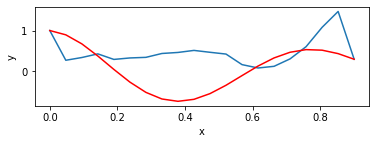

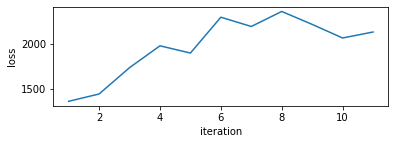

In [27]:
dqc53_2=DQCSolver(qubit=5, depth=3, backend=backend, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result_2=dqc53_2.bb_solve(maxiter=10, tol=1e-7, lr=0.1, theta=result.x)

1474.5217773148852
1515.6878093280277
1555.784175168267
1565.6931478122297
1357.555544431109
1562.1904247617927
1607.266870315076
1509.81908640092
1659.6444478269266
1753.4994712222613
1577.7914388377587
1559.9400854462622
1642.222518122188
1634.6469480812807
1620.8298428149635
1470.0842487436973
1574.7466453847755
1520.6391433567364
1563.7797725126434
1597.1612491637213
1654.0994667116984
1685.602117789982
1516.5047671227505
1718.213712826308
1424.0650471128304
1687.9255129115995
1514.925897034599
1477.7991166962265
1651.5562816524268
1592.5451918989831
1544.1321613353416
1631.0159249593169
1527.2283490205193
1658.3415909769828
1505.587796644152
1384.5902541303492
1488.4241459964228
1516.0512531760917
1661.8343117508846
1525.56489069757
1550.811881864288
1623.4965005966517
1587.5647308311084
1418.8478683775197
1610.7616776022714
1520.163967112946
1472.231937930598
1431.7154996663594
1586.4106103863771
1589.5836184842954
1383.3048362545806
1523.193763977136
1397.1848485880437
1614.8039

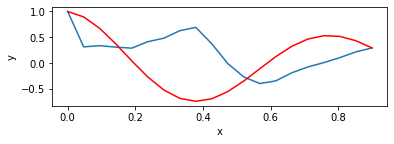

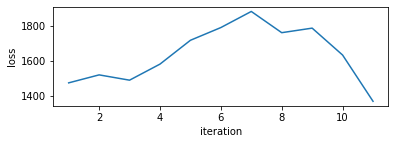

In [ ]:
dqc53=DQCSolver(qubit=5, depth=3, backend=backend, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result=dqc53.bb_solve(maxiter=10, tol=1e-7, lr=0.1, theta=None)

1474.5217773148852
1515.6878093280277
1555.784175168267
1565.6931478122297
1357.555544431109
1562.1904247617927
1607.266870315076
1509.81908640092
1659.6444478269266
1753.4994712222613
1577.7914388377587
1559.9400854462622
1642.222518122188
1634.6469480812807
1620.8298428149635
1470.0842487436973
1574.7466453847755
1520.6391433567364
1563.7797725126434
1597.1612491637213
1654.0994667116984
1685.602117789982
1516.5047671227505
1718.213712826308
1424.0650471128304
1687.9255129115995
1514.925897034599
1477.7991166962265
1651.5562816524268
1592.5451918989831
1544.1321613353416
1631.0159249593169
1527.2283490205193
1658.3415909769828
1505.587796644152
1384.5902541303492
1488.4241459964228
1516.0512531760917
1661.8343117508846
1525.56489069757
1550.811881864288
1623.4965005966517
1587.5647308311084
1418.8478683775197
1610.7616776022714
1520.163967112946
1472.231937930598
1431.7154996663594
1586.4106103863771
1589.5836184842954
1383.3048362545806
1523.193763977136
1397.1848485880437
1614.8039

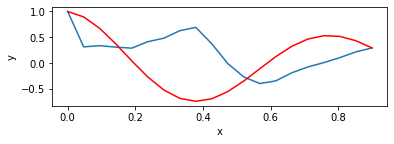

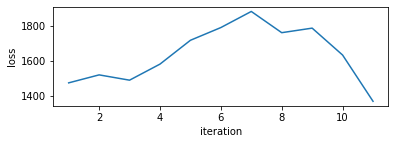

In [ ]:
dqc53=DQCSolver(qubit=5, depth=3, backend=backend, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result=dqc53.bb_solve(maxiter=10, tol=1e-7, lr=0.1, theta=None)